## Heart Attack Analysis Report: Group 44

### Introduction

Heart disease is a prevalent and life-threatening condition that affects millions of people worldwide. Early diagnosis and risk assessment are crucial in providing timely medical intervention and reducing the morbidity and mortality associated with this condition. In our data science project, we aim to leverage a [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) containing hospital data from Cleveland, Hungary, Switzerland, and VA Long Beach. However, we will specifically choose to work with the Cleveland data as it contains the most data from heart disease patients. The dataset contains 14 health-related variables, including the presence or absence of heart disease as the categorical variable. Using classification modelling, the data offers us a valuable opportunity to explore its relationship with heart disease. Hence, we propose to answer the question: Using KNN, how can we use medical laboratory test data available to us to predict whether a patient has heart disease?

## Methods & Results

First, we load all of the packages with the functions that are necessary to work the following data analysis.

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We set a seed value to ensure that the randomness in the following analysis is reproducible. Next, we create a vector to rename the 14 columns from the original data set to make it human-readable. 

Then, we read in the heart disease data and store it as `heart_data`. However, for our analysis, we will only be using the following column variables: `cp` (chest pain type), `trestbps` (resting blood pressure), `chol` (serum cholesterol levels), `fbs` (fasting blood sugar), `restecg` (resting electrocardiogram results), and `num` (diagnosis of heart disease). 

The original data set characterizes a diagnosis of heart disease by the numbers 1, 2, 3, and 4 in varying levels of severity, and a diagnosis of no heart disease by the number 0. In our analysis, we simplify this by setting the categories: diagnosis of heart disease - 0 = false; 1 = true.   

In [2]:
set.seed(1)
# creating column names for our data as it does not contain
our_col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# reading in our data and storing as an object
heart_data <- read_csv("data/processed.cleveland.data", col_names = our_col_names) |>
    select(cp, trestbps, chol, fbs, restecg, num) |>
    mutate(num = ifelse(num %in% c(1, 2, 3, 4), 1, num)) |>
    mutate(num = as_factor(num))
    
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cp,trestbps,chol,fbs,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,145,233,1,2,0
4,160,286,0,2,1
4,120,229,0,2,1
3,130,250,0,0,0
2,130,204,0,2,0
2,120,236,0,0,0


In [10]:
set.seed(1)

# prepare data for splitting
split_obj <- initial_split(heart_data, prop = 0.8, strata = num)

# split and extract data
train_data <- training(split_obj)
test_data <- testing(split_obj)


# calculcate summary statistics
summary_diagnosis <- train_data |>
    group_by(num) |>
    summarize(count = n()) |>
    pivot_wider(names_from = num,
                values_from = count)

# summary_diagnosis

summary_means <- train_data |>
    select(trestbps, chol) |>
    summarize_all(mean, na.rm = TRUE)

# summary_means

summary_table <- cbind(summary_means, summary_diagnosis) |>
    rename("resting blood pressure (mean)" = trestbps,
          "serum cholesterol (mean)" = chol,
          "no disease" = `0`,
          "disease" = `1`)
           
summary_table

resting blood pressure (mean),serum cholesterol (mean),no disease,disease
<dbl>,<dbl>,<int>,<int>
131.5165,244.3388,131,111


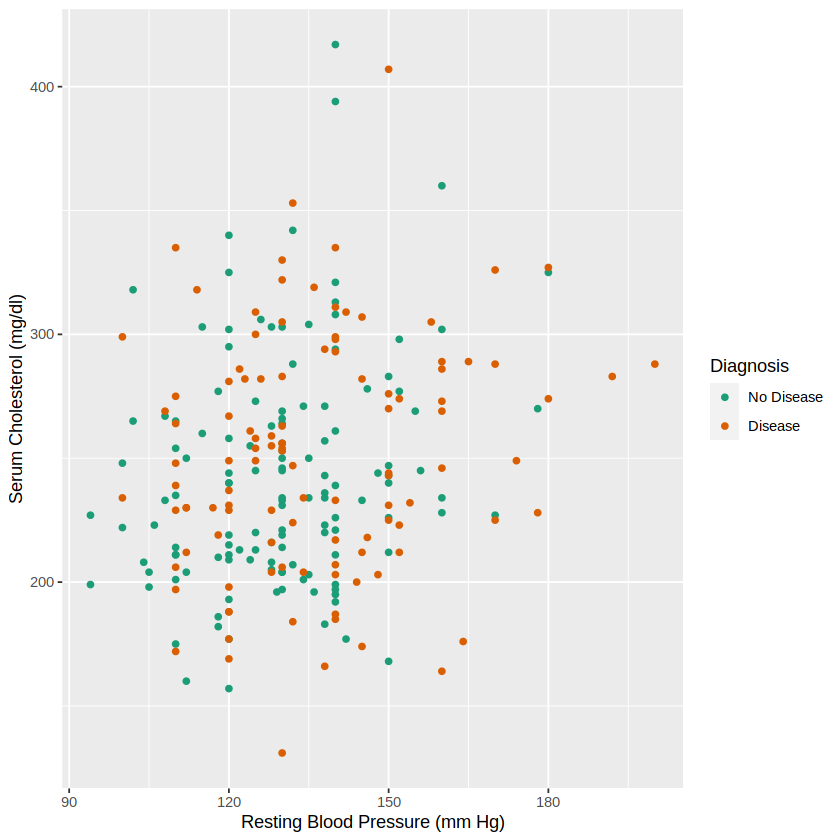

In [4]:
visualization1 <- train_data |>
    ggplot(aes(x=trestbps,  y=chol, colour= as_factor(num))) +
    geom_point() +
    labs(x="Resting Blood Pressure (mm Hg)", y="Serum Cholesterol (mg/dl)", colour = "Diagnosis") +
    scale_color_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

visualization1

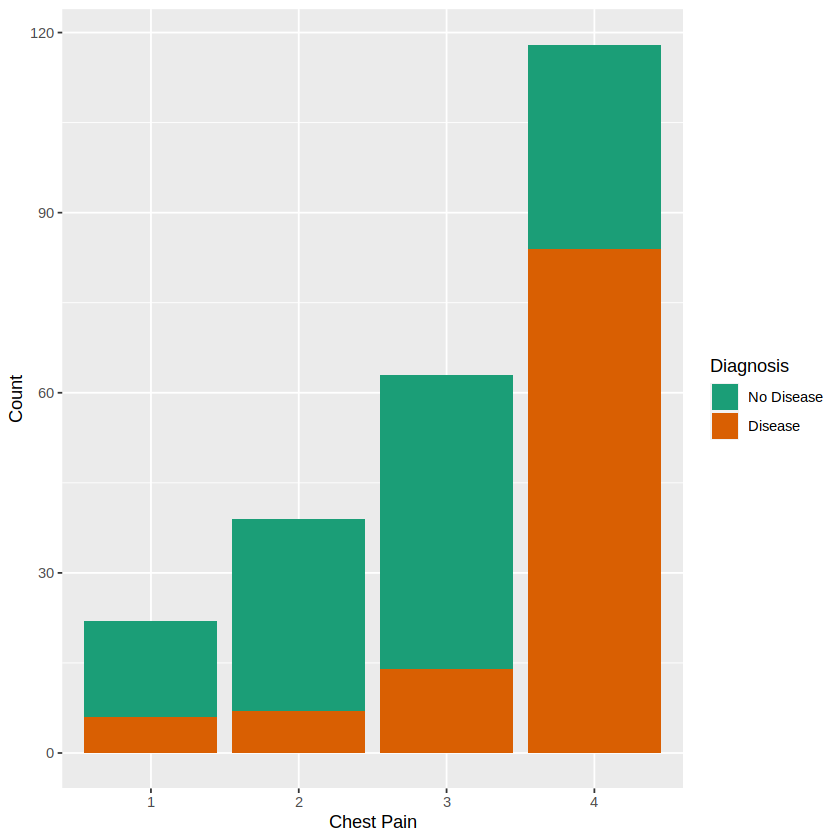

In [5]:
#9 cp: chest pain type
        #-- Value 1: typical angina
        #-- Value 2: atypical angina
        #-- Value 3: non-anginal pain
        #-- Value 4: asymptomatic

cat_cp <- train_data |>
    ggplot(aes(x = as_factor(cp), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Chest Pain", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_cp

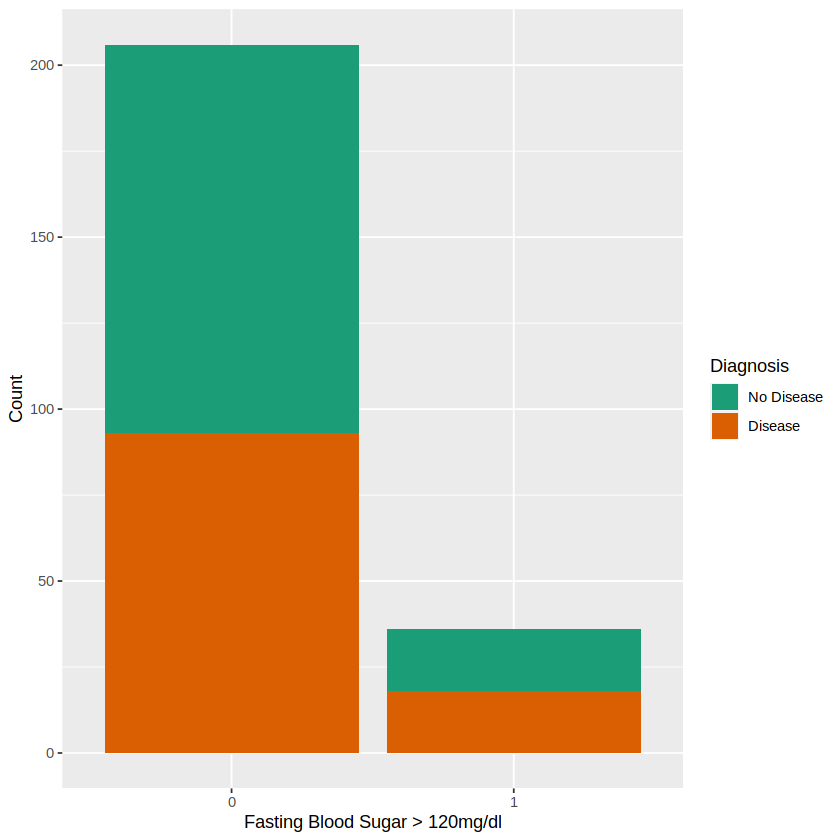

In [6]:
#16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

cat_fbs <- train_data |>
    ggplot(aes(x = as_factor(fbs), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Fasting Blood Sugar > 120mg/dl", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_fbs

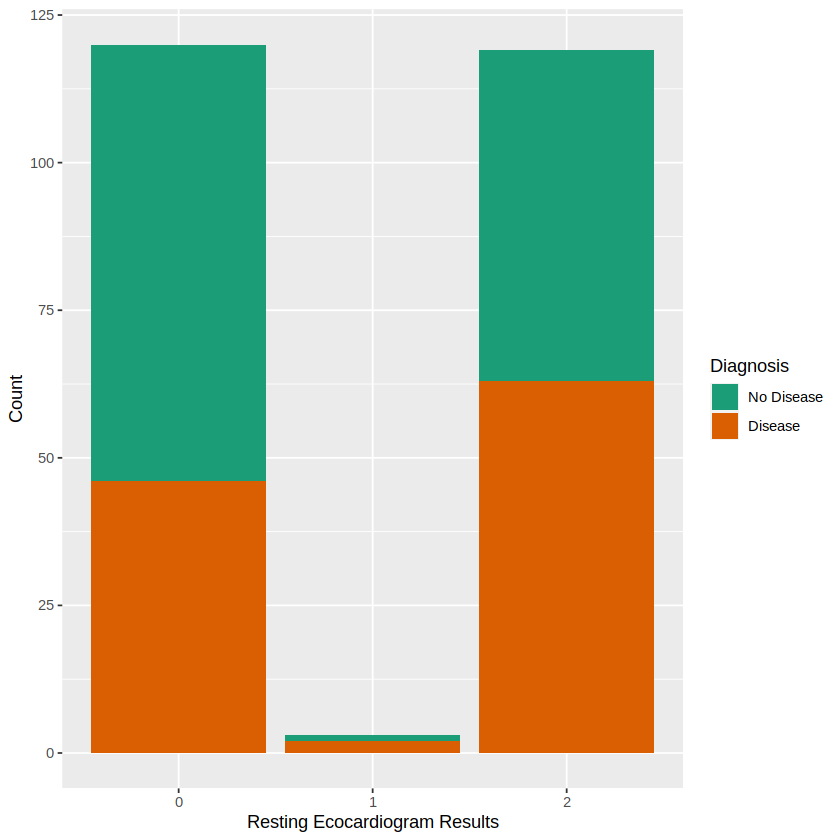

In [7]:
#19 restecg: resting electrocardiographic results
        #-- Value 0: normal
        #-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        #-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

cat_restecg <- train_data |>
    ggplot(aes(x = as_factor(restecg), fill = as_factor(num))) +
    geom_bar(stat = "count") +
    labs(x = "Resting Ecocardiogram Results", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_restecg

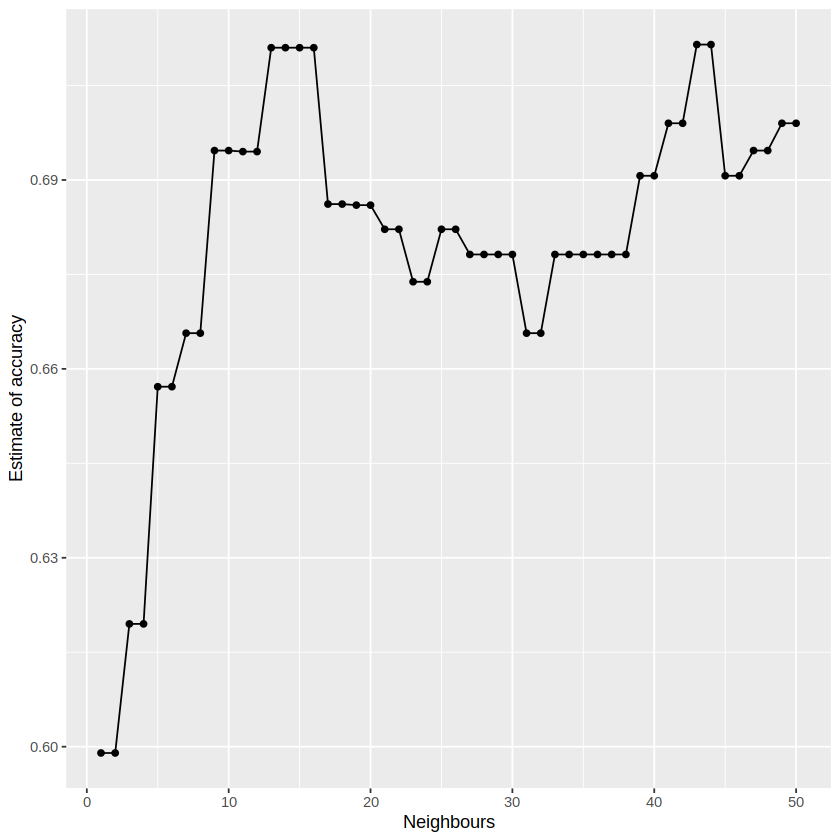

In [17]:
knn_recipe <- recipe(num ~., train_data)
    

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("classification") 

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

heart_vfold <- vfold_cv(train_data, v = 5, strata = num)

k_values <- tibble(neighbors=seq(from=1,to=50))

knn_results <- knn_workflow |>
    tune_grid(resamples = heart_vfold, grid=k_values) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric== "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbours", y="Estimate of accuracy")
cross_val_plot